In [1]:
import time

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.init as init
from torch.utils.data import DataLoader, TensorDataset, Dataset
import torch.nn.functional as F

from dataclasses import dataclass

### Create Data Loader

In [2]:
df = pd.read_csv('../dataset/ng_density_all.csv')
df

,Pressure,Temperature,Density,NG_TYPE,Methane,Ethane,Propane,2-methylpropane,Butane,2-metylbutane,Pentane,Octane,Toluene,Methylcyclopentane,Nitrogen,Carbon Dioxide
0,15,250,243.81,1,0.84990,0.05529,0.02008,0.00401,0.00585,0.00169,0.00147,0.00152,0.0009,0.00102,0.03496,0.02331
1,20,250,285.62,1,0.84990,0.05529,0.02008,0.00401,0.00585,0.00169,0.00147,0.00152,0.0009,0.00102,0.03496,0.02331
2,25,250,311.50,1,0.84990,0.05529,0.02008,0.00401,0.00585,0.00169,0.00147,0.00152,0.0009,0.00102,0.03496,0.02331
3,30,250,330.07,1,0.84990,0.05529,0.02008,0.00401,0.00585,0.00169,0.00147,0.00152,0.0009,0.00102,0.03496,0.02331
4,35,250,344.55,1,0.84990,0.05529,0.02008,0.00401,0.00585,0.00169,0.00147,0.00152,0.0009,0.00102,0.03496,0.02331
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1235,45,450,201.43,5,0.85094,0.05529,0.02009,0.00401,0.00612,0.00171,0.00141,0.00152,0.0000,0.00099,0.03496,0.02296
1236,50,450,215.93,5,0.85094,0.05529,0.02009,0.00401,0.00612,0.00171,0.00141,0.00152,0.0000,0.00099,0.03496,0.02296
1237,55,450,229.11,5,0.85094,0.05529,0.02009,0.00401,0.00612,0.00171,0.00141,0.00152,0.0000,0.00099,0.03496,0.02296
1238,60,450,241.15,5,0.85094,0.05529,0.02009,0.00401,0.00612,0.00171,0.00141,0.00152,0.0000,0.00099,0.03496,0.02296


In [3]:
df.drop('NG_TYPE', axis=1).info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1240 entries, 0 to 1239
Data columns (total 15 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Pressure            1240 non-null   int64  
 1   Temperature         1240 non-null   int64  
 2   Density             1240 non-null   float64
 3   Methane             1240 non-null   float64
 4   Ethane              1240 non-null   float64
 5   Propane             1240 non-null   float64
 6   2-methylpropane     1240 non-null   float64
 7   Butane              1240 non-null   float64
 8   2-metylbutane       1240 non-null   float64
 9   Pentane             1240 non-null   float64
 10  Octane              1240 non-null   float64
 11  Toluene             1240 non-null   float64
 12  Methylcyclopentane  1240 non-null   float64
 13  Nitrogen            1240 non-null   float64
 14  Carbon  Dioxide     1240 non-null   float64
dtypes: float64(13), int64(2)
memory usage: 145.4 KB


In [4]:
# Assuming df is your DataFrame
# Binning Pressure and Temperature
# This Pressure and Temperature label will be use to stratify our data split process
pressure_bins = pd.cut(df['Pressure'], bins=5, labels=False)
temperature_bins = pd.cut(df['Temperature'], bins=5, labels=False)
stratify_labels = pressure_bins.astype(str) + '_' + temperature_bins.astype(str)

# Since our data is already on memory (DataFrame) we will split it right away (not using Tensor Sampler)
# Splitting the dataset into 60% train, 20% validation, 20% test
train_df, temp_df = train_test_split(df, test_size=0.4, stratify=stratify_labels, random_state=42)
valid_df, test_df = train_test_split(temp_df, test_size=0.5, stratify=stratify_labels[temp_df.index], random_state=42)

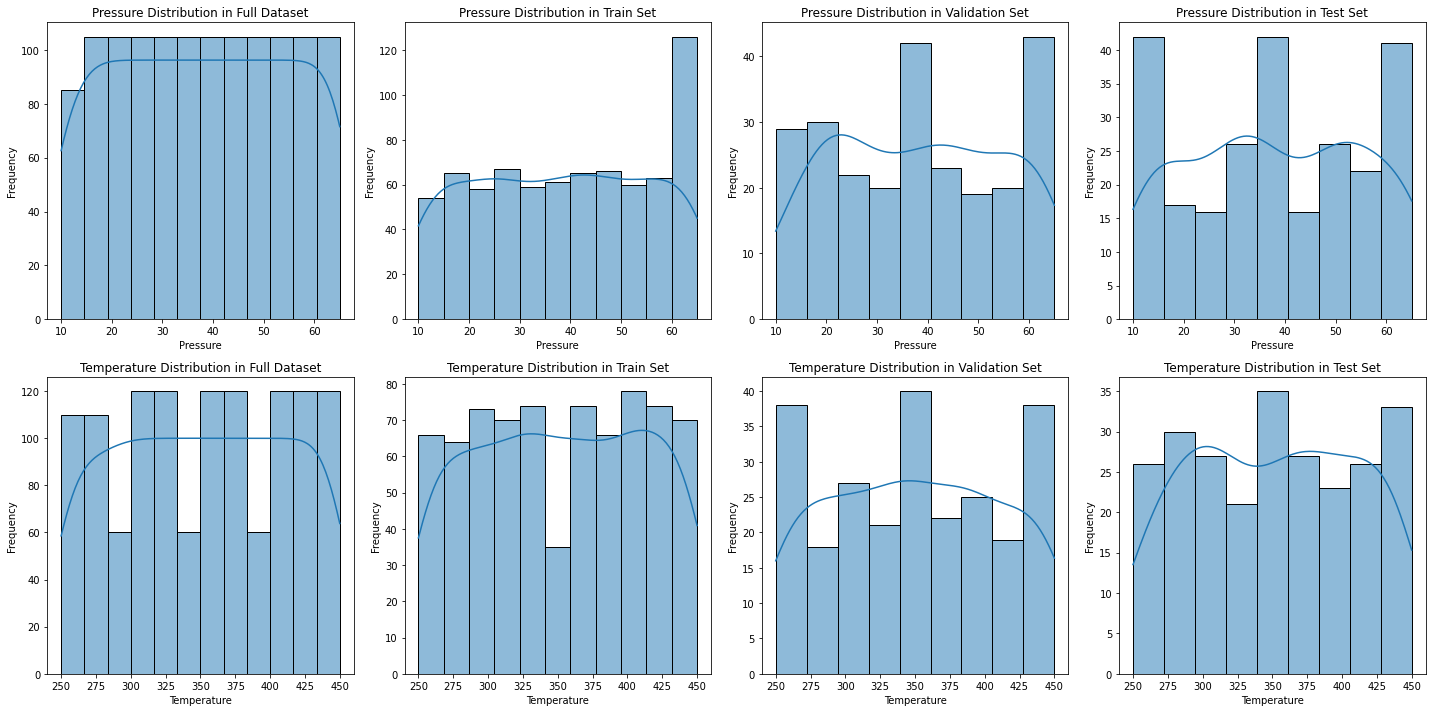

In [5]:
# Assuming train_df, valid_df, test_df, and df (entire dataset) are already defined
def plot_distribution(data, column, label, ax):
    sns.histplot(data[column], kde=True, ax=ax)
    ax.set_title(f'{column} Distribution in {label}')
    ax.set_xlabel(column)
    ax.set_ylabel('Frequency')

fig, axs = plt.subplots(2, 4, figsize=(20, 10))  # Adjust the size as needed

# Plotting for Pressure
plot_distribution(df, 'Pressure', 'Full Dataset', axs[0, 0])
plot_distribution(train_df, 'Pressure', 'Train Set', axs[0, 1])
plot_distribution(valid_df, 'Pressure', 'Validation Set', axs[0, 2])
plot_distribution(test_df, 'Pressure', 'Test Set', axs[0, 3])

# Plotting for Temperature
plot_distribution(df, 'Temperature', 'Full Dataset', axs[1, 0])
plot_distribution(train_df, 'Temperature', 'Train Set', axs[1, 1])
plot_distribution(valid_df, 'Temperature', 'Validation Set', axs[1, 2])
plot_distribution(test_df, 'Temperature', 'Test Set', axs[1, 3])

plt.tight_layout()
plt.show()

In [6]:
X_train = train_df.drop(['Density', 'NG_TYPE'], axis=1).values
y_train = train_df['Density'].values
X_valid = valid_df.drop(['Density', 'NG_TYPE'], axis=1).values
y_valid = valid_df['Density'].values
X_test = test_df.drop(['Density', 'NG_TYPE'], axis=1).values
y_test = test_df['Density'].values

In [7]:
# Calculate mean and standard deviation for Pressure and Temperature in the training data
pressure_mean = X_train[:, 0].mean()
pressure_std = X_train[:, 0].std()
temperature_mean = X_train[:, 1].mean()
temperature_std = X_train[:, 1].std()

# Apply normalization to Pressure and Temperature in all sets (train, validation, and test)
X_train_normalized = X_train.copy()
X_train_normalized[:, 0] = (X_train[:, 0] - pressure_mean) / pressure_std
X_train_normalized[:, 1] = (X_train[:, 1] - temperature_mean) / temperature_std

X_valid_normalized = X_valid.copy()
X_valid_normalized[:, 0] = (X_valid[:, 0] - pressure_mean) / pressure_std
X_valid_normalized[:, 1] = (X_valid[:, 1] - temperature_mean) / temperature_std

X_test_normalized = X_test.copy()
X_test_normalized[:, 0] = (X_test[:, 0] - pressure_mean) / pressure_std
X_test_normalized[:, 1] = (X_test[:, 1] - temperature_mean) / temperature_std

In [8]:
# Convert the normalized data to PyTorch tensors
X_train_tensor = torch.tensor(X_train_normalized, dtype=torch.float32)
X_valid_tensor = torch.tensor(X_valid_normalized, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test_normalized, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
y_valid_tensor = torch.tensor(y_valid, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

In [9]:
# Define params
batch_size = 64
torch.manual_seed(42)

# Create TensorDatasets
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
valid_dataset = TensorDataset(X_valid_tensor, y_valid_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

# Create Tensor DataLoaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [10]:
num_x_train = 0
batch_x_train = 0
for x, y in train_loader:
    # print(x.shape)
    num_x_train += x.shape[0]
    batch_x_train += 1

num_x_valid = 0
batch_x_valid = 0
for x, y in valid_loader:
    # print(x.shape)
    num_x_valid += x.shape[0]
    batch_x_valid += 1

num_x_test = 0
batch_x_test = 0
for x, y in test_loader:
    # print(x.shape)
    num_x_test += x.shape[0]
    batch_x_test += 1

print(batch_x_train, num_x_train)
print(batch_x_valid, num_x_valid)
print(batch_x_test, num_x_test)

12 744
4 248
4 248


### Baseline Model
Using simple LinearRegression ML Model

In [11]:
base_model = LinearRegression()
base_model.fit(X_train, y_train)

y_pred = base_model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
aard = 100*np.mean(np.abs(y_pred - y_test) / y_test)
r2 = r2_score(y_test, y_pred)

print("base_model coef(s):", base_model.coef_)
print("Mean Squared Error:", mse)
print("RMSE:", rmse)
print("AARD:", aard)
print("R² Score:", r2)

base_model coef(s): [ 3.94401882e+00 -8.05349243e-01 -8.27344668e+02  5.30700054e+02
  1.40003478e+03 -7.22788910e+01 -7.19328664e+02 -1.81339490e+03
 -1.50970338e+02  3.73892129e+00  8.34954358e+02  1.48359544e+03
 -1.08409396e+03  3.83962758e+02]
Mean Squared Error: 436.72044246265625
RMSE: 20.89785736535342
AARD: 9.717686638793937
R² Score: 0.9419966234632798


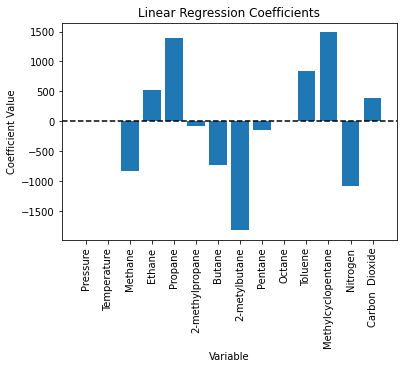

In [12]:
plt.bar(train_df.drop(['Density', 'NG_TYPE'], axis=1).columns, base_model.coef_)
plt.title("Linear Regression Coefficients")
plt.xlabel("Variable")
plt.ylabel("Coefficient Value")
plt.xticks(rotation=90)
plt.axhline(y=0, color='k', linestyle='--')
plt.show()

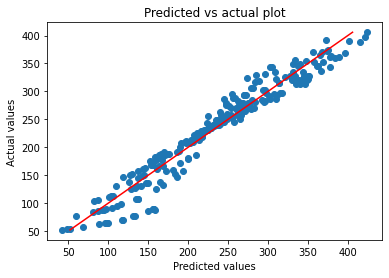

In [13]:
plt.scatter(y_pred, y_test)
plt.xlabel('Predicted values')
plt.ylabel('Actual values')
plt.title('Predicted vs actual plot')
plt.plot(np.linspace(min(y_test), max(y_test), 100), np.linspace(min(y_test), max(y_test), 100), color='red')
plt.show()

### Create the Inference and Train function

In [14]:
@torch.no_grad() # Add decorator to exclude the gradient in calculation
def get_inference(model, criterion, type):
  '''Get the model accuracy'''
  # Map the data loader
  data_loader = {
    'train': train_loader,
    'valid': valid_loader,
    'test': test_loader
  }[type]

  total_loss = 0

  model.eval()
  for i, (inputs, targets) in enumerate(data_loader):
    # Predict
    outputs = model(inputs)

    # Calcualte the loss
    total_loss += criterion(outputs, targets.unsqueeze(1)).item()

  # Find the mean loss
  loss = total_loss/len(data_loader)

  return total_loss


In [15]:
def train(model, criterion, max_epoch, train_loader, optimizer):
  '''Train the model'''
  # Init
  train_losses_list = []
  valid_losses_list = []
  losses = []

  # Start Iteration
  start_time = time.time()
  for epoch in range(max_epoch):
    # Training -- iterate over batch
    model.train()
    for batch_idx, (inputs, targets) in enumerate(train_loader):
      # Forward pass
      outputs = model(inputs)
      loss = criterion(outputs, targets.unsqueeze(1))

      # Backward and optimize
      optimizer.zero_grad()
      loss.backward()

      # Update the model parameter
      optimizer.step()

      # Log the minibatch (inner iteration)
      losses.append(loss.item())
      if not batch_idx % int(len(train_loader)/2.):
        print(f'Epoch: {epoch+1:03d}/{max_epoch:03d} '
              f'| Batch: {batch_idx:04d}/{len(train_loader):04d} '
              f'| Loss: {loss:.4f}')

    # Inference and evaluate model
    # Evaluate the model
    model.eval()
    with torch.no_grad():
        train_loss = get_inference(model, criterion, 'train')
        valid_loss = get_inference(model, criterion, 'valid')

        print(f'Epoch: {epoch+1:03d}/{max_epoch:03d} '
              f'| Train: {train_loss:.4f}'
              f'| Valid: {valid_loss:.4f}')
        print('')

        train_losses_list.append(train_loss)
        valid_losses_list.append(valid_loss)
  
  # Finalize
  elapsed_time = (time.time() - start_time)
  print(f'Total training time: {elapsed_time/60:.0f} min {elapsed_time%60:.2f} sec')

  return losses, train_losses_list, valid_losses_list

### Preparing the Model

In [16]:
# Create a config class

@dataclass
class ModelConfig:
    # Config model
    n_in: int = X_train.shape[1]  # input size
    n_hidden: int = 250           # hidden layer size
    n_out: int = 1                # output size (1 for regeression case)
    
    # Config train
    lr: float = 0.1             # learning rates
    max_epochs: int = 100        # maximum epochs

In [17]:
CONFIG = ModelConfig()
CONFIG

ModelConfig(n_in=14, n_hidden=250, n_out=1, lr=0.1, max_epochs=100)

In [18]:
class MLP(nn.Module):
    def __init__(self, config):
        super().__init__()

        # Create the MLP
        torch.manual_seed(42)

        # Flatten layer
        self.flatten = nn.Flatten()

        # 1st hidden layer
        self.fc1 = nn.Linear(config.n_in, config.n_hidden)
        init.kaiming_normal_(self.fc1.weight, mode='fan_in', nonlinearity='relu')

        # ReLU activation function
        self.relu = nn.ReLU()

        # Output layer
        self.fc2 = nn.Linear(config.n_hidden, config.n_out)
        init.kaiming_normal_(self.fc2.weight, mode='fan_in', nonlinearity='relu')

    def forward(self, X):
        X = self.flatten(X)
        X = self.relu(self.fc1(X))
        pred_density = self.fc2(X)
        return pred_density

### Training process

In [19]:
# Initialize models
model_mlp = MLP(CONFIG)

# Print number of parameters
print('Total parameters :', sum(p.nelement() for p in model_mlp.parameters()))

Total parameters : 4001


In [20]:
# Define optimizer
optimizer_adam = torch.optim.Adam(params = model_mlp.parameters(),
                               lr = CONFIG.lr,
                               betas = (0.9, 0.999))

optimizer_sgd = optim.SGD(model_mlp.parameters(), lr=CONFIG.lr)

In [21]:
# Define Loss Function
criterion = nn.MSELoss()

In [22]:
losses_mlp, train_loss_mlp, valid_loss_mlp = train(model=model_mlp,
                                                  criterion=criterion,
                                                  max_epoch=CONFIG.max_epochs,
                                                  train_loader=train_loader,
                                                  optimizer=optimizer_adam)

Epoch: 001/100 | Batch: 0000/0012 | Loss: 51918.4258
Epoch: 001/100 | Batch: 0006/0012 | Loss: 15011.5645
Epoch: 001/100 | Train: 150218.5654| Valid: 49921.9844

Epoch: 002/100 | Batch: 0000/0012 | Loss: 12572.9492
Epoch: 002/100 | Batch: 0006/0012 | Loss: 1441.7671
Epoch: 002/100 | Train: 42009.4822| Valid: 14299.8289

Epoch: 003/100 | Batch: 0000/0012 | Loss: 2978.5735
Epoch: 003/100 | Batch: 0006/0012 | Loss: 1070.9908
Epoch: 003/100 | Train: 10061.9564| Valid: 3010.2167

Epoch: 004/100 | Batch: 0000/0012 | Loss: 691.9511
Epoch: 004/100 | Batch: 0006/0012 | Loss: 1037.4689
Epoch: 004/100 | Train: 5383.6777| Valid: 1552.8485

Epoch: 005/100 | Batch: 0000/0012 | Loss: 431.6488
Epoch: 005/100 | Batch: 0006/0012 | Loss: 488.8209
Epoch: 005/100 | Train: 5236.1739| Valid: 1635.1536

Epoch: 006/100 | Batch: 0000/0012 | Loss: 328.6098
Epoch: 006/100 | Batch: 0006/0012 | Loss: 359.8935
Epoch: 006/100 | Train: 4654.3098| Valid: 1361.0757

Epoch: 007/100 | Batch: 0000/0012 | Loss: 458.1989
Epo

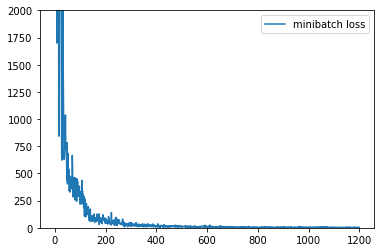

In [23]:
plt.plot(np.arange(len(losses_mlp)), losses_mlp, c='tab:blue', label='minibatch loss')
plt.ylim([0, 2000])
plt.legend()
plt.show()

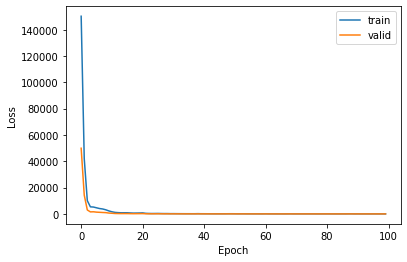

In [24]:
plt.plot(np.arange(len(train_loss_mlp)), train_loss_mlp, c='tab:blue', label='train')
plt.plot(np.arange(len(valid_loss_mlp)), valid_loss_mlp, c='tab:orange', label='valid')
plt.ylabel('Loss'); plt.xlabel('Epoch')
# plt.ylim(75, 100)
plt.legend()
plt.show()

In [25]:
model_mlp.eval()
y_pred_list = []

with torch.no_grad():
  for inputs, targets in test_loader:
    # print(inputs)
    y_test_pred = model_mlp(inputs)
    y_pred_list.append(y_test_pred.numpy())

y_pred_mlp = np.vstack(y_pred_list).flatten()

In [26]:
train_df['Temperature'].max()

450

In [27]:
mse = mean_squared_error(y_test, y_pred_mlp)
rmse = np.sqrt(mse)
aard = 100*np.mean(np.abs(y_pred_mlp - y_test) / y_test)
r2 = r2_score(y_test, y_pred_mlp)

print("Mean Squared Error:", mse)
print("Root Mean Squared Error:", rmse)
print("AARD:", aard)
print("R² Score:", r2)

Mean Squared Error: 3.0963106077040226
Root Mean Squared Error: 1.7596336572434679
AARD: 0.7266158853575051
R² Score: 0.9995887610182831


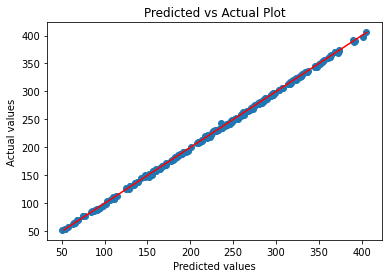

In [28]:
plt.scatter(y_pred_mlp, y_test)
plt.xlabel('Predicted values')
plt.ylabel('Actual values')
plt.title('Predicted vs Actual Plot')
plt.plot(np.linspace(min(y_test), max(y_test), 100), np.linspace(min(y_test), max(y_test), 100), color='red')
plt.show()

### Comparison with EoS Calcualtion (Peng-Robinson)

In [29]:
# each data obtained ~0.01s
filename = '../dataset/Natural gas density data_1_dwsim.xlsx'
df_peng_rob = pd.read_excel(filename, sheet_name='Sheet1')
df_peng_rob.columns = ["Temperature", "Pressure", "Density", "NG_TYPE"]
df_peng_rob['Pressure'] = df_peng_rob['Pressure']/1e6 
df_peng_rob

,Temperature,Pressure,Density,NG_TYPE
0,250,10.0,156.862,1
1,250,15.0,237.106,1
2,250,20.0,278.841,1
3,250,25.0,306.522,1
4,250,30.0,327.052,1
...,...,...,...,...
1255,450,45.0,200.531,5
1256,450,50.0,215.319,5
1257,450,55.0,228.874,5
1258,450,60.0,241.335,5


Comparison between DWSIM EoS Calculation (w/ Peng-Robinson) to Actual Density data

In [30]:
merge_test_df = pd.merge(test_df, df_peng_rob, on=['Temperature', 'Pressure', 'NG_TYPE'], how='left')
merge_test_df = merge_test_df[merge_test_df['Density_y'] != 0] # some data can't be calcualted by PR EoS DWSIM

mse = mean_squared_error(merge_test_df['Density_x'], merge_test_df['Density_y'])
rmse = np.sqrt(mse)
aard = 100*np.mean(np.abs(merge_test_df['Density_y'] - merge_test_df['Density_x']) / merge_test_df['Density_x'])
r2 = r2_score(merge_test_df['Density_x'], merge_test_df['Density_y'])

print("Mean Squared Error:", mse)
print("Root Mean Squared Error:", rmse)
print("AARD:", aard)
print("R² Score:", r2)

Mean Squared Error: 4.967480162479337
Root Mean Squared Error: 2.228784458506326
AARD: 0.7172930655302037
R² Score: 0.9993223509159536


### Hyperparameter Tuning

In [45]:
n_hidden_list = np.arange(50, 350, 50)
results_df = pd.DataFrame(columns=['n_hidden', 'total_params', 'mse', 'rmse', 'aard', 'r2', 'training_time'])

for n_hidden in n_hidden_list:
  print(f"Trial on: hidden layer's nueron number {n_hidden}")
  _CONFIG = ModelConfig()
  _CONFIG.n_hidden = n_hidden
  # Initialize models
  model_mlp_tuning = MLP(_CONFIG)

  # Print number of parameters
  print('Total parameters :', sum(p.nelement() for p in model_mlp_tuning.parameters()))

  # Define optimizer
  optimizer_adam = torch.optim.Adam(params = model_mlp_tuning.parameters(),
                                lr = 0.1,
                                betas = (0.9, 0.999))
  
  # Define Loss Function
  criterion = nn.MSELoss()

  start_time_tuning = time.time()
  losses_mlp, train_loss_mlp, valid_loss_mlp = train(model=model_mlp_tuning,
                                                    criterion=criterion,
                                                    max_epoch=_CONFIG.max_epochs,
                                                    train_loader=train_loader,
                                                    optimizer=optimizer_adam)
  total_time_tuning = time.time() - start_time_tuning

  # Check RMSE and R2 Score
  model_mlp_tuning.eval()
  y_pred_list = []

  with torch.no_grad():
    for inputs, targets in test_loader:
      # print(inputs)
      y_test_pred = model_mlp_tuning(inputs)
      y_pred_list.append(y_test_pred.numpy())

  y_pred_mlp = np.vstack(y_pred_list).flatten()

  mse = mean_squared_error(y_test, y_pred_mlp)
  rmse = np.sqrt(mse)
  aard = 100*np.mean(np.abs(y_pred_mlp - y_test) / y_test)
  r2 = r2_score(y_test, y_pred_mlp)

  print("Mean Squared Error:", mse)
  print("Root Mean Squared Error:", rmse)
  print("AARD:", aard)
  print("R² Score:", r2)

  results_df = results_df.append({'n_hidden': n_hidden,
                                'total_params': sum(p.nelement() for p in model_mlp_tuning.parameters()),
                                'mse': mse,
                                'rmse': rmse,
                                'aard': aard,
                                'r2': r2,
                                'training_time': total_time_tuning},
                                ignore_index=True)
  
  print("-------------------")
  print()

Trial on: hidden layer's nueron number 50
Total parameters : 801
Epoch: 001/100 | Batch: 0000/0012 | Loss: 61411.4375
Epoch: 001/100 | Batch: 0006/0012 | Loss: 44212.8164
Epoch: 001/100 | Train: 280123.2598| Valid: 96449.9023

Epoch: 002/100 | Batch: 0000/0012 | Loss: 22688.3184
Epoch: 002/100 | Batch: 0006/0012 | Loss: 1377.6976
Epoch: 002/100 | Train: 83123.0332| Valid: 26988.0205

Epoch: 003/100 | Batch: 0000/0012 | Loss: 7009.3906
Epoch: 003/100 | Batch: 0006/0012 | Loss: 1524.1807
Epoch: 003/100 | Train: 14328.1974| Valid: 4947.7650

Epoch: 004/100 | Batch: 0000/0012 | Loss: 1394.9832
Epoch: 004/100 | Batch: 0006/0012 | Loss: 1521.9005
Epoch: 004/100 | Train: 6051.7609| Valid: 1910.0073

Epoch: 005/100 | Batch: 0000/0012 | Loss: 650.9420
Epoch: 005/100 | Batch: 0006/0012 | Loss: 601.1681
Epoch: 005/100 | Train: 6046.1992| Valid: 1764.0089

Epoch: 006/100 | Batch: 0000/0012 | Loss: 468.4883
Epoch: 006/100 | Batch: 0006/0012 | Loss: 481.7845
Epoch: 006/100 | Train: 5420.9048| Valid:

C:\Users\HardoTriwahyu\AppData\Local\Temp\ipykernel_5460\3596617996.py:52: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'n_hidden': n_hidden,



Epoch: 005/100 | Train: 5858.2164| Valid: 1852.5795

Epoch: 006/100 | Batch: 0000/0012 | Loss: 446.8817
Epoch: 006/100 | Batch: 0006/0012 | Loss: 407.1701
Epoch: 006/100 | Train: 4975.9741| Valid: 1466.6501

Epoch: 007/100 | Batch: 0000/0012 | Loss: 348.1386
Epoch: 007/100 | Batch: 0006/0012 | Loss: 470.8067
Epoch: 007/100 | Train: 4350.7959| Valid: 1370.2169

Epoch: 008/100 | Batch: 0000/0012 | Loss: 304.0258
Epoch: 008/100 | Batch: 0006/0012 | Loss: 301.6358
Epoch: 008/100 | Train: 3640.4803| Valid: 1125.5893

Epoch: 009/100 | Batch: 0000/0012 | Loss: 260.8075
Epoch: 009/100 | Batch: 0006/0012 | Loss: 326.2429
Epoch: 009/100 | Train: 2753.1941| Valid: 844.3042

Epoch: 010/100 | Batch: 0000/0012 | Loss: 234.2064
Epoch: 010/100 | Batch: 0006/0012 | Loss: 164.7235
Epoch: 010/100 | Train: 1883.4932| Valid: 575.6694

Epoch: 011/100 | Batch: 0000/0012 | Loss: 127.4461
Epoch: 011/100 | Batch: 0006/0012 | Loss: 114.7896
Epoch: 011/100 | Train: 1336.1468| Valid: 397.8286

Epoch: 012/100 | Ba

C:\Users\HardoTriwahyu\AppData\Local\Temp\ipykernel_5460\3596617996.py:52: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'n_hidden': n_hidden,


Epoch: 004/100 | Train: 8378.9636| Valid: 2733.2850

Epoch: 005/100 | Batch: 0000/0012 | Loss: 864.9730
Epoch: 005/100 | Batch: 0006/0012 | Loss: 456.1091
Epoch: 005/100 | Train: 5406.5058| Valid: 1579.0988

Epoch: 006/100 | Batch: 0000/0012 | Loss: 614.8113
Epoch: 006/100 | Batch: 0006/0012 | Loss: 310.9705
Epoch: 006/100 | Train: 4511.8282| Valid: 1327.5866

Epoch: 007/100 | Batch: 0000/0012 | Loss: 491.6164
Epoch: 007/100 | Batch: 0006/0012 | Loss: 344.9294
Epoch: 007/100 | Train: 4435.9772| Valid: 1370.0602

Epoch: 008/100 | Batch: 0000/0012 | Loss: 235.8368
Epoch: 008/100 | Batch: 0006/0012 | Loss: 386.8811
Epoch: 008/100 | Train: 4448.5681| Valid: 1279.1393

Epoch: 009/100 | Batch: 0000/0012 | Loss: 342.0746
Epoch: 009/100 | Batch: 0006/0012 | Loss: 245.3869
Epoch: 009/100 | Train: 4109.8132| Valid: 1245.8652

Epoch: 010/100 | Batch: 0000/0012 | Loss: 422.1567
Epoch: 010/100 | Batch: 0006/0012 | Loss: 258.5216
Epoch: 010/100 | Train: 4094.0593| Valid: 1241.0242

Epoch: 011/100 | 

C:\Users\HardoTriwahyu\AppData\Local\Temp\ipykernel_5460\3596617996.py:52: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'n_hidden': n_hidden,


Epoch: 002/100 | Batch: 0000/0012 | Loss: 10306.5684
Epoch: 002/100 | Batch: 0006/0012 | Loss: 786.4135
Epoch: 002/100 | Train: 45914.3870| Valid: 15811.5425

Epoch: 003/100 | Batch: 0000/0012 | Loss: 3927.7224
Epoch: 003/100 | Batch: 0006/0012 | Loss: 569.7876
Epoch: 003/100 | Train: 14607.6230| Valid: 4328.4023

Epoch: 004/100 | Batch: 0000/0012 | Loss: 1318.9197
Epoch: 004/100 | Batch: 0006/0012 | Loss: 632.1150
Epoch: 004/100 | Train: 6051.0794| Valid: 1852.0767

Epoch: 005/100 | Batch: 0000/0012 | Loss: 411.2794
Epoch: 005/100 | Batch: 0006/0012 | Loss: 424.9910
Epoch: 005/100 | Train: 4966.2074| Valid: 1460.1831

Epoch: 006/100 | Batch: 0000/0012 | Loss: 363.9969
Epoch: 006/100 | Batch: 0006/0012 | Loss: 413.5534
Epoch: 006/100 | Train: 4505.9167| Valid: 1365.2726

Epoch: 007/100 | Batch: 0000/0012 | Loss: 285.9227
Epoch: 007/100 | Batch: 0006/0012 | Loss: 330.2693
Epoch: 007/100 | Train: 4319.3443| Valid: 1252.6191

Epoch: 008/100 | Batch: 0000/0012 | Loss: 486.8753
Epoch: 008/1

C:\Users\HardoTriwahyu\AppData\Local\Temp\ipykernel_5460\3596617996.py:52: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'n_hidden': n_hidden,


Epoch: 003/100 | Train: 10061.9564| Valid: 3010.2167

Epoch: 004/100 | Batch: 0000/0012 | Loss: 691.9511
Epoch: 004/100 | Batch: 0006/0012 | Loss: 1037.4689
Epoch: 004/100 | Train: 5383.6777| Valid: 1552.8485

Epoch: 005/100 | Batch: 0000/0012 | Loss: 431.6488
Epoch: 005/100 | Batch: 0006/0012 | Loss: 488.8209
Epoch: 005/100 | Train: 5236.1739| Valid: 1635.1536

Epoch: 006/100 | Batch: 0000/0012 | Loss: 328.6098
Epoch: 006/100 | Batch: 0006/0012 | Loss: 359.8935
Epoch: 006/100 | Train: 4654.3098| Valid: 1361.0757

Epoch: 007/100 | Batch: 0000/0012 | Loss: 458.1989
Epoch: 007/100 | Batch: 0006/0012 | Loss: 463.5664
Epoch: 007/100 | Train: 4091.4352| Valid: 1229.7667

Epoch: 008/100 | Batch: 0000/0012 | Loss: 405.0352
Epoch: 008/100 | Batch: 0006/0012 | Loss: 428.9669
Epoch: 008/100 | Train: 3759.5478| Valid: 1100.7610

Epoch: 009/100 | Batch: 0000/0012 | Loss: 369.0177
Epoch: 009/100 | Batch: 0006/0012 | Loss: 316.2188
Epoch: 009/100 | Train: 3152.5765| Valid: 985.0057

Epoch: 010/100 |

C:\Users\HardoTriwahyu\AppData\Local\Temp\ipykernel_5460\3596617996.py:52: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'n_hidden': n_hidden,



Epoch: 005/100 | Batch: 0006/0012 | Loss: 338.8225
Epoch: 005/100 | Train: 5771.7766| Valid: 1798.5454

Epoch: 006/100 | Batch: 0000/0012 | Loss: 422.2855
Epoch: 006/100 | Batch: 0006/0012 | Loss: 312.5296
Epoch: 006/100 | Train: 4661.4498| Valid: 1416.4108

Epoch: 007/100 | Batch: 0000/0012 | Loss: 400.8556
Epoch: 007/100 | Batch: 0006/0012 | Loss: 542.0599
Epoch: 007/100 | Train: 4375.5309| Valid: 1298.2228

Epoch: 008/100 | Batch: 0000/0012 | Loss: 219.4240
Epoch: 008/100 | Batch: 0006/0012 | Loss: 512.7392
Epoch: 008/100 | Train: 4261.7863| Valid: 1300.2401

Epoch: 009/100 | Batch: 0000/0012 | Loss: 509.0289
Epoch: 009/100 | Batch: 0006/0012 | Loss: 419.4265
Epoch: 009/100 | Train: 4312.6136| Valid: 1275.9921

Epoch: 010/100 | Batch: 0000/0012 | Loss: 365.2078
Epoch: 010/100 | Batch: 0006/0012 | Loss: 594.9891
Epoch: 010/100 | Train: 4191.4410| Valid: 1325.2453

Epoch: 011/100 | Batch: 0000/0012 | Loss: 232.1960
Epoch: 011/100 | Batch: 0006/0012 | Loss: 309.5662
Epoch: 011/100 | T

C:\Users\HardoTriwahyu\AppData\Local\Temp\ipykernel_5460\3596617996.py:52: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'n_hidden': n_hidden,


In [46]:
results_df

,n_hidden,total_params,mse,rmse,aard,r2,training_time
0,50.0,801.0,33.296096,5.770277,2.599052,0.995578,3.385209
1,100.0,1601.0,27.925514,5.284460,2.356624,0.996291,2.924287
2,150.0,2401.0,7.363586,2.713593,1.194228,0.999022,3.501719
3,200.0,3201.0,3.720268,1.928800,0.809225,0.999506,4.414591
4,250.0,4001.0,3.096311,1.759634,0.726616,0.999589,4.033350
5,300.0,4801.0,2.911497,1.706311,0.753190,0.999613,3.901572


In [33]:
def inference_single_data(data_dict: dict):
  ''' 
  Simple function to get input data as dict and then return the predicted density 
  P: in MPa
  T: in Kelvin (K)
  rho (density): in kg/m3
  '''
  
  required_keys = set(['Pressure', 'Temperature', 'Methane', 'Ethane', 'Propane', '2-methylpropane', 'Butane', '2-metylbutane', 'Pentane', 'Octane', 'Toluene', 'Methylcyclopentane', 'Nitrogen', 'Carbon Dioxide'])
  if set(data_dict.keys()) != required_keys:
    raise Exception(f"The data sequence must follow this: {required_keys}")
  
  data_dict_arr = np.array(list(data_dict.values()))

  # pressure_mean, presure_std, temperature_mean, temperature_std are data calculated from train_data
  data_dict_arr = data_dict_arr.copy()
  data_dict_arr[0] = (data_dict_arr[0] - pressure_mean) / pressure_std
  data_dict_arr[1] = (data_dict_arr[1] - temperature_mean) / temperature_std

  # Convert NumPy array to PyTorch tensor and convert to float data type
  input_tensor = torch.from_numpy(data_dict_arr).float()

  # Predict the single input using the model
  y_test_pred = model_mlp(input_tensor.unsqueeze(0))

  return y_test_pred.item()

In [34]:
sample_data_1 = {
    'Pressure': 30,
    'Temperature': 350,
    'Methane': 0.759522443,
    'Ethane': 0.086174251,
    'Propane': 0.0584332,
    '2-methylpropane': 0.012103352,
    'Butane': 0.01393312,
    '2-metylbutane': 0,
    'Pentane': 0.006430073,
    'Octane': 0.001287943,
    'Toluene': 0.000643971,
    'Methylcyclopentane': 0,
    'Nitrogen': 0.061251704,
    'Carbon Dioxide': 0.00000528,
}

sample_data_2 = {
    'Pressure': 30,
    'Temperature': 350,
    'Methane': 0.759522443,
    'Ethane': 0.086174251,
    'Propane': 0.0584332,
    '2-methylpropane': 0.012103352,
    'Butane': 0.01393312,
    '2-metylbutane': 0,
    'Pentane': 0.006430073,
    'Octane': 0.001287943,
    'Toluene': 0.000643971,
    'Methylcyclopentane': 0,
    'Nitrogen': 0.061251704,
    'Carbon Dioxide': 0.00000528,
}

sample_data_2 = {}
for i, (k, v) in enumerate(sample_data_1.items()):
  sample_data_2[k] = X_train[0][i]
sample_data_2['Pressure'] = 30

In [44]:
inference_single_data(sample_data_2)

208.44064331054688

In [48]:
elapsed_time_list = []
for i in range(1, 1001):
  start_time = time.time()
  inference_single_data(sample_data_2)
  elapsed_time_list.append(time.time() - start_time)

print(f"Average elapsed time: {sum(elapsed_time_list)/len(elapsed_time_list):.6f}s")


Average elapsed time: 0.000087s
